# Análise de estratégia de portfólio

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from geopy.geocoders import Nominatim
import plotly.offline as py
import plotly.graph_objs as go
py.init_notebook_mode(connected=True)
import geopy
from geopy.extra.rate_limiter import RateLimiter
import plotly.express as px

In [2]:
def locate_neighborhood(coordinates: str) -> str:
    locator = Nominatim(user_agent='myGeocoder', timeout=10)
    rgeocode = RateLimiter(locator.reverse, min_delay_seconds=0.001)
    location = locator.reverse(coordinates)
    
    split_address = location.address.split(',')
    
    if len(split_address) == 11:
        return split_address[2][1:]
    
    return split_address[3][1:]

In [3]:
simulated = pd.read_csv('simulated_listings.csv')

simulated.rename(inplace=True, columns={
    'Unnamed: 0':'Apartment_ID',
    'rooms':'Rooms',
    'garages':'Garage',
    'useful_area':'Useful_Area',
    'latitude':'Latitude',
    'longitude':'Longitude', 
    'value':'Market_Value',
    'interior_quality':'Condition',
    'time_on_market':'Time_on_Market',
    'sold': 'Sold'
})
simulated['Latitude'] = simulated['Latitude'].astype(str)
simulated['Longitude'] = simulated['Longitude'].astype(str)
simulated['Condition'] = simulated['Condition'].astype(str)
simulated['Coordinates'] = simulated['Latitude'] + ', ' + simulated['Longitude']

In [4]:
target = pd.read_csv('target_apartments.csv')

target.rename(inplace=True, columns={
    'Unnamed: 0':'Apartment_ID',
    'rooms':'Rooms',
    'garages':'Garage',
    'useful_area':'Useful_Area',
    'latitude':'Latitude',
    'longitude':'Longitude', 
    'value':'Seller_Value',
    'interior_quality':'Condition'})
target['Latitude'] = target['Latitude'].astype(str)
target['Longitude'] = target['Longitude'].astype(str)
target['Coordinates'] = target['Latitude'] + ', ' + target['Longitude']

In [5]:
simulated.sort_values(['Time_on_Market','Sold'], axis = 0, ascending=True, inplace=True)

In [6]:
sold = simulated.copy()[simulated['Sold'] == 1]
selling = simulated.copy()[simulated['Sold'] == 0]

In [7]:
top10_liquidity = sold.head(10)
top10_liquidity = top10_liquidity.assign(Neighborhood=top10_liquidity.apply(lambda row: locate_neighborhood(row['Coordinates']), axis = 1));

tail10_liquidity = sold.tail(10)
tail10_liquidity = tail10_liquidity.assign(Neighborhood=tail10_liquidity.apply(lambda row: locate_neighborhood(row['Coordinates']), axis = 1));

In [8]:
neighborhoods = top10_liquidity['Neighborhood'].drop_duplicates().tolist()
neighborhoods_count = top10_liquidity['Neighborhood'].value_counts().tolist()

conditions = sold['Condition'].drop_duplicates().tolist()
conditions_count = sold['Condition'].value_counts().tolist()

# Contexto

O mercado imobiliário sempre foi bastante burocrático e temido por grande parte da população que busca adquirir seu imóvel, seja ele o primeiro ou não.
Dessa forma, a tecnologia deve ser a nossa maior aliada no combate da burocracia e entrega de um produto com valor agregado e maior assertividade ao nosso cliente. O objetivo desse estudo é entender o comportamento de vendas de apartamentos pela cidade de São Paulo, as preferencias e características mais procuradas pelos compradores para compormos uma carteira com apartamentos diversos, mas que sejam líquidos e tragam retorno, gerando assim um ambiente saudável de desenvolvimento da empresa.


# Hipóteses 

Dado o momento atual, encontramos as seguintes questões e suas respectivas hipóteses e variáveis presentes na compra de um imóvel:
A Loft deveria comprar o apartamento e transacionar através do IBuyer, ou apenas anunciá-lo no marketplace?
- Os compradores estudam as condições do imóvel antes de adquiri-lo? Se sim, é importante estudar qual a preferência deles em relação ao estado de conservação;
- Quais são os bairros mais líquidos, e dentre eles, qual estrutura de apartamento é a mais buscada e comprada.
Qual o preço justo de anúncio dos apartamentos, tanto para o comprador quanto para a estratégia de desenvolvimento da Loft?
- Caso o apartamento esteja em um bairro líquido, e esteja em uma condição não totalmente reformado, qual a margem de ganhos que a Loft prevê sobre esse imóvel.
- Se os apartamentos já se encontram em estado 3 de conservação e são menos líquidos, de qual forma podemos anuncia-los de maneira mais assertiva em nossa plataforma.

# Objetivos


Nosso principal objetivo através desse estudo é encontrar uma forma de preencher mais nossa carteira de imóveis de forma mais coerente com nossos planos e mais assertiva com os compradores que entram em nossa plataforma em busca de seu imóvel. 

# Métricas

Uma estratégia de portfólio tem como objetivo ter os melhores produtos e oferecê-los da melhor forma aos nossos consumidores. Dessa forma, nosso maior indicador de sucesso é o número de apartamentos vendidos, e a quantidade de tempo que eles permanecem na nossa plataforma até a sua venda. Isso pode ser considerada uma das facetas na classificação de um ativo líquido em relação ao outro.

# Decisões para serem tomadas baseadas nos resultados

Como dito anteriormente, nosso objetivo é ampliar o número de apartamentos disponíveis na nossa plataforma. Dessa forma, vamos estudar nichos específicos de informação, buscando padrões entre elas a fim de estabelecer determinado comportamento e determinar as melhores opções de aquisições de apartamentos para o nosso portfólio.


# Testes e Grupos de Informações

Através da análise de dados de apartamentos que já estão em nossa plataforma, selecionamos algumas variáveis para serem a base de nosso estudo. Os dados escolhidos forma os seguintes: Número de dias disponível na plataforma, bairro, condições e tamanho.

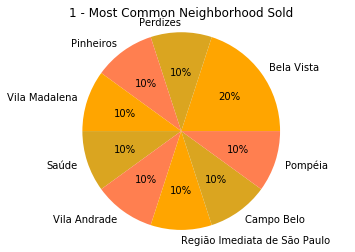

Rooms,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,Total,% Apartment
Condition,,,,,,,,,,
1,45,130,233,134,9,1,0,0,552,11.1%
2,108,354,576,390,9,0,1,1,1439,29.1%
3,214,696,1208,816,26,2,0,0,2962,59.8%


In [9]:
fig1, ax1 = plt.subplots()

ax1.pie(neighborhoods_count, 
        labels=neighborhoods, 
        autopct='%1.0f%%', 
        shadow=False, 
        startangle=360, 
        colors=['orange', 'goldenrod', 'coral']
)
ax1.axis('equal') 
plt.title('1 - Most Common Neighborhood Sold')
plt.show()

sold_cross = pd.crosstab(sold['Condition'], sold['Rooms'])
sold_cross['Total'] = sold_cross.sum(axis=1)
sold_cross['% Apartment'] = sold['Condition'] \
    .value_counts(normalize=True) \
    .mul(100) \
    .round(1) \
    .astype(str) + '%'
    
sold_cross


Através dos nossos dados, expostos acima no gráfico 1 e tabela, conseguimos estabelecer alguns padrões para o consumo de imóveis através da nossa plataforma. A maioria dos apartamentos vendidos encontram-se na zona oeste da cidade de São Paulo, e sua condição mais comum é a 3, que é o modelo de reforma da Loft através do IBuyer, seguidos da condição 2.

Ainda analisando a tabela acima, podemos notar que os apartamentos com um número médio de 3 dormitórios são os favoritos entre os nossos clientes, e podemos concluir que são apartamentos mais “apostáveis” para incluir em nosso portfólio.



Os preços de cada um dos apartamentos também é uma das características fundamentais para o comprador fechar o negócio, por isso, mapeamos abaixo a faixa de preços atingidas por diferentes tipos de aparamento, baseado no número de quartos, e consequentemente no tamanho dos apartamentos que foram vendidos através da nossa plataforma.

In [10]:
def calculate_y_for_rooms(rooms_count):
    return sold.loc[sold['Rooms'] == rooms_count, 'Market_Value']

trace1 = go.Box(y=calculate_y_for_rooms(1),
                name='1 Room',
                marker={'color': '#f39c12'})
trace2 = go.Box(y=calculate_y_for_rooms(2),
                name='2 Rooms',
                marker={'color': '#e67e22'})
trace3 = go.Box(y=calculate_y_for_rooms(3),
                name='3 Rooms',
                marker={'color': '#d35400'})
trace4 = go.Box(y=calculate_y_for_rooms(4),
                name='4 Rooms',
                marker={'color': '#ea8685'})
trace5 = go.Box(y=calculate_y_for_rooms(5),
                name='5 Rooms',
                marker={'color': '#f19066'})
trace8 = go.Box(y=calculate_y_for_rooms(8),
                name='8 Rooms',
                marker={'color': '#f3a683'})

data = [trace1, trace2, trace3, trace4, trace5, trace8]
layout = go.Layout(title='Price dispersion for apartments with different rooms',
                   titlefont={'family': 'Arial',
                              'size': 22,
                              'color': '#7f7f7f'},
                   xaxis={'title': 'Rooms'},
                   yaxis={'title': 'Price'},
                   paper_bgcolor='rgb(243, 243, 243)',
                   plot_bgcolor='rgb(243, 243, 243)')
fig = go.Figure(data=data, layout=layout)
py.iplot(fig)

Levando em consideração todas essas variáveis, dividimos a nossa base de apartamentos entre ‘Vendidos’ e ‘Vendendo’, para ter uma maior visualização da relação entre eles e as condições oferecidas na plataforma. Dessa maneira, podemos dizer com mais precisão qual condição de apartamento devemos ter em maior quantidade em nossa plataforma. E qual tipo de condição podemos apenas negociar através do marketplace, tornando nosso sistema mais sustentável e rentável.


No gráfico abaixo, podemos ter clareza em relação aos apartamentos vendidos e em processo de venda que estão disponíveis em nossa base de dados.


In [11]:
condition_selling_count = selling['Condition'].value_counts().tolist()

conditions_selling_name = selling['Condition'].drop_duplicates().tolist()

trace1 = go.Bar(x=conditions,
                y=conditions_count,
                name='Apartment sold',
                marker={'color': '#F06023'})

trace2 = go.Bar(x=conditions_selling_name,
                y=condition_selling_count,
                name='Apartment selling',
                marker={'color': '#EB8D1A'})

data = [trace1, trace2]

layout = go.Layout(title = 'Relationship between sold and selling based on condition',
                   xaxis = {'title': 'Condition'},
                   yaxis = {'title': '# of Apartments'},
                   barmode = 'stack')
fig = go.Figure(data=data, layout=layout)
py.iplot(fig)

Considerando todos os dados já apresentamos, avaliaremos apartamentos que poderão ou não fazer parte do portfólio da Loft seguindo a mesma lógica para selecionarmos ou não um imóvel.


In [12]:
def build_action(row):
    if row['Rooms'] <= 3 and row['Condition'] == 1:
        return 'Buy'
    
    return 'Not Yet'

target['Action'] = target.apply(build_action, axis=1)

In [19]:
target_buy = target.query('Rooms != 1 & Action == "Buy" & Useful_Area > 65 & Useful_Area < 180')

try:
    target_buy = target_buy.assign(Neighborhood=target_buy.apply(lambda row: locate_neighborhood(row['Coordinates']), axis=1))
except:
    target_buy = pd.read_csv('target_buy_fallback.csv')

In [14]:
neighborhoods.remove('Região Imediata de São Paulo')
final_buy = target_buy[target_buy['Neighborhood'].isin(neighborhoods)]

In [15]:
final_buy

,Apartment_ID,Rooms,Garage,Useful_Area,Latitude,Longitude,Seller_Value,Condition,Coordinates,Action,Neighborhood
202,1337,2.0,3.0,140,-23.540126899999997,-46.679508399999996,1409730,1,"-23.540126899999997, -46.679508399999996",Buy,Perdizes
291,16067,2.0,1.0,88,-23.6151088,-46.6589862,574665,1,"-23.6151088, -46.6589862",Buy,Saúde
398,236,2.0,1.0,85,-23.539367000000002,-46.680335,838258,1,"-23.539367000000002, -46.680335",Buy,Perdizes
603,3294,2.0,2.0,134,-23.5637016,-46.6848775,1236310,1,"-23.5637016, -46.6848775",Buy,Pinheiros
774,11790,3.0,2.0,95,-23.6353103,-46.7345075,717463,1,"-23.6353103, -46.7345075",Buy,Vila Andrade
...,...,...,...,...,...,...,...,...,...,...,...
8487,3270,2.0,3.0,162,-23.5728202,-46.690583200000006,4304870,1,"-23.5728202, -46.690583200000006",Buy,Pinheiros
8576,16560,3.0,3.0,176,-23.619711399999996,-46.6404614,1729790,1,"-23.619711399999996, -46.6404614",Buy,Saúde
8745,755,3.0,1.0,70,-23.5342895,-46.683607099999996,931262,1,"-23.5342895, -46.683607099999996",Buy,Perdizes
8857,1392,2.0,2.0,83,-23.548478399999997,-46.6931176,740215,1,"-23.548478399999997, -46.6931176",Buy,Pinheiros


In [16]:
neighborhood_buys = final_buy['Neighborhood'].drop_duplicates().tolist()
neighborhood_buy_count = final_buy['Neighborhood'].value_counts().tolist()

trace1 = go.Scatter(x=neighborhood_buys,
                    y=neighborhood_buy_count,
                    mode='lines+markers+text',
                    name='Apartments by neighborhood',
                    line={'color': '#F06023',
                          'dash': 'dash'})

data = [trace1]
py.iplot(data)

# Conclusão

Através da definição de regras e atributos que um apartamento teria para ser considerado "líquido", estabelecemos uma linha de corte para os apartamentos listados na base "target_apartments.csv", e chegamos ao resultado apresentado através do dataframe "final_buy". Esses apartamentos seriam considerados os melhores para serem adquiridos pela Loft e depois reformados e por fim vendidos na plataforma. 
Acima também encontramos uma representação gráfica do número de apartamentos por bairro, o que mostra a tendencia dos bairros mais comprados e preferidos dos nossos clientes. 

Com essas informações em mente, podemos seguir para os próximos passos que devemos realizar com esses apartamentos.

In [17]:
mean_price_to_buy = final_buy.mean()['Seller_Value']
total_price_to_buy = final_buy.sum()['Seller_Value']
sold_condition_3 = sold.filter(like='3', axis=0)
mean_price_sold = sold_condition_3.mean()['Market_Value']

median_price_to_buy = final_buy.median()['Seller_Value']
median_price_sold = sold_condition_3.median()['Market_Value']

In [18]:
diff_price =  mean_price_sold - mean_price_to_buy
diff_price_percent = ((diff_price / mean_price_to_buy)*100).astype(str) + '%'
    
diff_median = median_price_sold - median_price_to_buy
diff_median_percent = ((diff_median / median_price_to_buy)*100).astype(str) + '%'

financial_data = pd.DataFrame([(diff_median, diff_price, diff_price_percent, diff_median_percent)], columns = ['diff_median', 'diff_price', 'diff_price_percent', 'diff_median_percent'])
financial_data

,diff_median,diff_price,diff_price_percent,diff_median_percent
0,377105.0,860370.168609,79.74580564905412%,41.110996037218534%


# Metodologia de preços

Como demonstrado no dataframe acima (financial_data), temos uma variação considerável na diferença de valores dos apartamentos uma vez que são comprados pela Loft, reformados e depois disponibilizados na plataforma.
Essa diferença é a diretriz para definir a metodologia dos preços que serão aplicados nos apartamentos que serão transacionados via IBuyer, dessa forma podemos definir uma margem média de retorno dos apartamentos, com os dados acima, identificamos uma valorização de no mínimo 41.11% dos apartamentos que passam por esse processo, e em média, ao generalizarmos um pouco mais o nosso modelo, podemos chegar a resultados de lucros ainda maiores. Então podemos definir que um bom número para adicionarmos ao preço do apartamento depois de reformado, é de 45% até 48%, para que a Loft seja capaz de agradar o seu cliente e fidelizá-lo, não esperando apenas novas compras, mas também divulgação para amigos e familiares sobre a plataforma. 

Além disso, podemos destacar também apartamentos que devem estar em nossa plataforma através de anúncio de parceiros, as melhores apostas seguem os seguintes requisitos:
- Condição três, preferencialmente;
- Bairros entre zona oeste e zona sul da capital;
